# CSE488 Project

I want you to pretend you are competing in http://celltrackingchallenge.net/.  Unfortunately, we missed the ISBI2024 deadline but practicing on a realistic challenges is good practice. There may be a 2025 challenge…..


**NOTE:** I am sharing this on colab, but you will likely want to run jupyter locally to do this project.  Colab will kick you out and you will lose your data after a few hours unless you pay them.

# Data and Starter Code

The goal of this project is to successfully segment cell images.

You will use the evaluation programs provided by the challenge creators to evaluate your results.  The cells below will download the testing program.

In [1]:
# Initial cell (automatically executed)
try:
  import imagecodecs   # Needed to open compressed tif files
except:
  %pip install imagecodecs  # Needed to open compressed tif files

import os
from IPython.display import clear_output
clear_output()

In order for data to persist on Google colab, I have this set up to link to your Google Drive account.   
You may instead wish to work locally, which would inolve installing Jupyter instead.  [Instructions are here](https://test-jupyter.readthedocs.io/en/latest/install.html).   

The next cell should only be executed if you are using colab:

In [3]:
# Mount Google Drive (a popup window will show)
try:
  from google.colab import drive
  drive.mount('/gdrive')

  # Create a project folder if it does nto already exist, and SymLink to it.
  BASE_PATH='/gdrive/MyDrive/CSE488/Project'
  !mkdir -p {BASE_PATH}
  !ln -s {BASE_PATH}

except ModuleNotFoundError:
  print("You appear to be running things locally, please set the BASE_PATH accordingly")
  BASE_PATH="C:\Users\ashfa\OneDrive\Desktop\CSE 488"

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1834136754.py, line 13)

This project is based on an official comptetition.   
The competition comes with (C++) code to evaluate your cell segmentation results uing the Jaccard index (intersection over union).  
The next cell downloads their code.  

**NOTE**: The cell assumes you are using Linux.

In [3]:
# Download the official evaluation software and uncompress it.
if not os.path.exists(f'{BASE_PATH}/Linux/SEGMeasure'):
  !wget http://public.celltrackingchallenge.net/software/EvaluationSoftware.zip -O {BASE_PATH}/EvaluationSoftware.zip
  !unzip {BASE_PATH}/EvaluationSoftware.zip -d {BASE_PATH}
  clear_output()

# Make SEGMeasure executable
import sys
if sys.platform != 'linux':
  print("You need to put the right version SEGMeasure in your path and make sure it is executable.")
else: # linux
  os.environ['PATH'] = f'{BASE_PATH}/Linux' + os.pathsep + os.environ['PATH']
  !chmod a+x {BASE_PATH}/Linux/SEGMeasure


You need to put the right version SEGMeasure in your path and make sure it is executable.


The input images come with associated ground-truth files.  
The names of the files are important (note the pattern [described here](https://public.celltrackingchallenge.net/documents/Naming%20and%20file%20content%20conventions.pdf))

Essentially:   
 -  The data is a set of videos. The file name starts with the video (e.g. 01)
 -  The labels are either manual "gold" truth  (01_GT)
 -  Or they are the consensus of automatic methods, "silver" truth (01_ST)
 -  The input files have named like `t001.tif` for which is the input at time 1.
 -  The target files for the semantic segmentation task (our chellenge) are named like `SEG/man_seg001.tif`.
 -  Your predictions will be in a folder like `01_RES` with a name like `mask001.tif`.

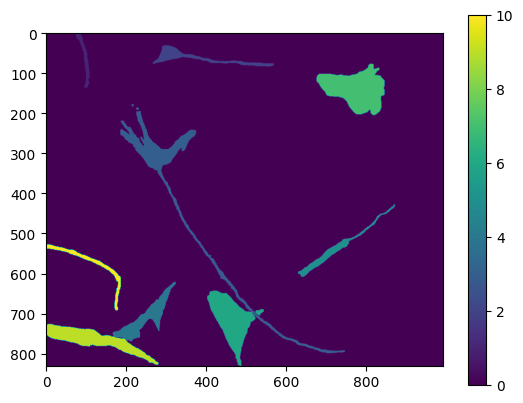

In [ ]:
from skimage import io
from matplotlib.pylab import plt

gt = io.imread('Project/testing_dataset/01_GT/SEG/man_seg045.tif')
plt.imshow(gt);
plt.colorbar()

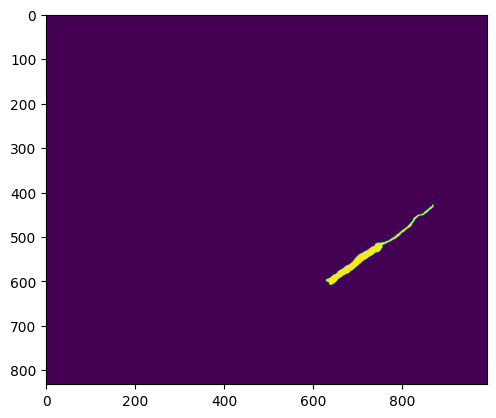

In [ ]:
plt.imshow(gt==5)

Your job is to produce a corresponding _results_ file

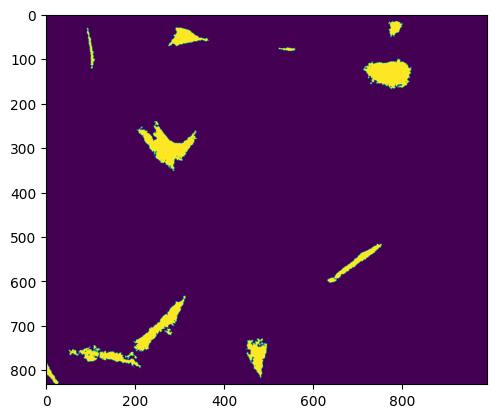

In [ ]:
result = io.imread('Project/testing_dataset/01_RES/mask045.tif')
plt.imshow(result >0)

The segmentation accuracy for this contest is based on:
1.   Matching a result with one of the GT objects (overlap > 50%)
2.   Computing the Intersection-over-Union (IoU) of the objects.

The IoU is also called the Jaccard index.  
To help you with debugging things and to make things clear, I have a python version of the evaluation code below:

In [ ]:
import numpy as np
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment

def compute_jaccard_index_for_matches(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask = label(seg_mask)
    # Extract properties of labeled regions
    mask_props = regionprops(labeled_mask)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in np.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize an array to hold overlaps with mask objects
        overlaps = []

        for prop in mask_props:
            # Calculate intersection and union with each segmented object
            intersection = np.sum(ref_object & (labeled_mask == prop.label))
            union = np.sum(ref_object | (labeled_mask == prop.label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * np.sum(ref_object):
                jaccard_index = intersection / union
                overlaps.append(jaccard_index)
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[ref_label] =best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = np.mean(list(jaccard_indices.values())) if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices


In [ ]:
metrics = compute_jaccard_index_for_matches(gt, result)

# IoU = Jaccard index (different name, same thing)
mIoU,  per_obj_IoUs = metrics
print(f"mIoU={mIoU}")
for object_index in per_obj_IoUs:
  print(f"Best IoU for target object {object_index:>3} is {per_obj_IoUs[object_index]}")

mIoU=0.16249413515519567
Best IoU for target object   1 is 0
Best IoU for target object   2 is 0.4962600690448792
Best IoU for target object   3 is 0
Best IoU for target object   4 is 0.5883534136546185
Best IoU for target object   5 is 0.540327868852459
Best IoU for target object   6 is 0
Best IoU for target object   7 is 0
Best IoU for target object   8 is 0
Best IoU for target object   9 is 0
Best IoU for target object  10 is 0


Your goal is to process an entire test set, and evaluate it using their evaluation program (similar to the python function I included above)

In [ ]:
if not os.path.isfile('MySEGMeasure.py'):
  !wget https://gist.github.com/jfemiani/81e5f6dbed8a949306d5a84df8f4e8eb/raw/144973730afaeb28640f3b0d10f7d311df410f3c/MySEGMeasure.py

# Explanation:
#   Put your validation data ST into a folder for the FIRST argument/
#      Filenames begin with man_seg###.tif
#   Put your results in a folder for the SECOND argument.
#      Filenames are mask####.tif
%run MySEGMeasure.py  {BASE_PATH}/testing_dataset/01_GT/SEG {BASE_PATH}/testing_dataset/01_RES

Mean Jaccard Index: 0.2328741243790547


<Figure size 640x480 with 0 Axes>

## Getting The Fluo-N2DH-GOWT1 Data Set

Several types of cell data are provided at http://celltrackingchallenge.net/2d-datasets/

For now, try to handle the mouse cells...

In [ ]:
BASE_PATH

'/gdrive/MyDrive/CSE488/Project'

In [ ]:
!mkdir -p {BASE_PATH}/training-datasets
!mkdir -p {BASE_PATH}/test-datasets

# Consider other datasets from http://celltrackingchallenge.net/2d-datasets/

if not os.path.exists('Project/training-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/training-datasets/

if not os.path.exists('Project/test-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/test-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/test-datasets/


Here is an example of one image

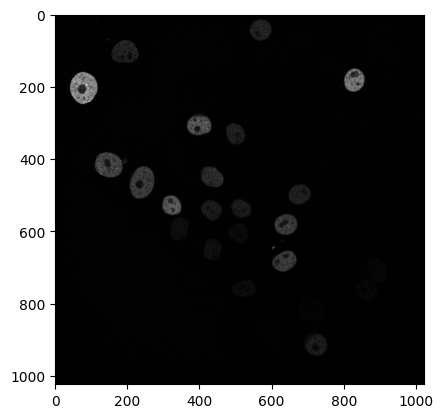

In [ ]:
plt.imshow(io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t000.tif'), cmap='gray');

Not every cell was labeled in the GT folder, so you may want to use the ST folder to tune your segmentation method.

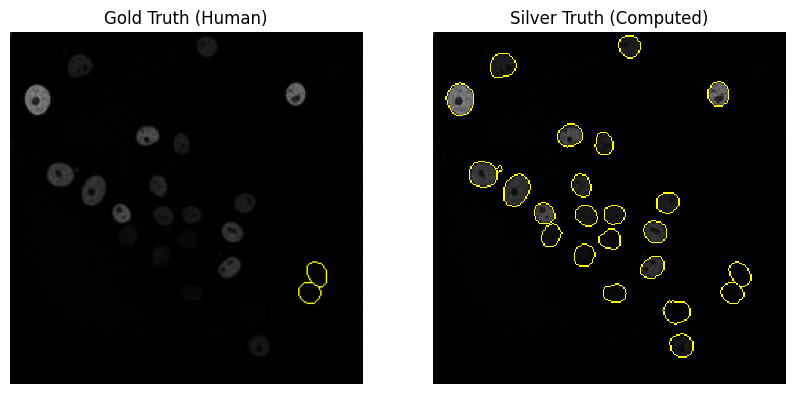

In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.transform import resize

plt.figure(figsize=(10,5))

# Shrinking images to make outlines clearere
input_image = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t005.tif')
input_image = resize(input_image, (256, 256))

plt.subplot(121)
gt_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/man_seg005.tif')
gt_segmentation = resize(gt_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, gt_segmentation))
plt.title("Gold Truth (Human)")
plt.axis('off')

plt.subplot(122)
st_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg005.tif')
st_segmentation = resize(st_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, st_segmentation), interpolation='nearest')
plt.title("Silver Truth (Computed)");
plt.axis('off');

# Goal

Your task is to try and classify the pixels in order to segment cells.

To help you out, I have a code snippet for neighborhood-based set of features to use for classifying.


In [ ]:
from skimage.util import view_as_windows
import pandas as pd

import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.util import view_as_windows

import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.util import view_as_windows
import os

def generate_image_features(image_path, mask_path, window_size=5, num_samples=10, pct_fg=0.5):
    # NOTE -- could be smart to normalize images here somehow...
    image = imread(image_path)
    mask = imread(mask_path).clip(0,1)

    # Process image and mask similarly, assuming they are aligned and have the same dimensions.
    height, width = image.shape
    padded_image = np.pad(image, (window_size-1)//2, mode='reflect')

    # Generate features from image
    image_features = view_as_windows(padded_image, (window_size, window_size))
    flat_features = image_features.reshape(height * width, window_size**2)

    # Flatten the mask to get target values directly corresponding to each feature
    flat_mask = mask.flatten()

    # Create DataFrame and assign targets
    df = pd.DataFrame(flat_features)
    df['target'] = flat_mask

    # Calculate sample weights based on desired foreground percentage
    num_fg = int(num_samples * pct_fg)
    num_bg = num_samples - num_fg
    fg_indices = df[df['target'] > 0].index
    bg_indices = df[df['target'] == 0].index

    # Sample from foreground and background
    fg_samples = df.loc[fg_indices].sample(n=num_fg, replace=True) if len(fg_indices) >= num_fg else df.loc[fg_indices]
    bg_samples = df.loc[bg_indices].sample(n=num_bg, replace=True) if len(bg_indices) >= num_bg else df.loc[bg_indices]

    # Combine and shuffle samples
    sample_df = pd.concat([fg_samples, bg_samples]).sample(frac=1).reset_index(drop=True)

    return sample_df


def process_images(image_mask_pairs, window_size, samples_per_image, pct_fg=0.5):
    frames = []
    for image_path, mask_path in image_mask_pairs:
        if os.path.exists(image_path) and os.path.exists(mask_path):
            df = generate_image_features(image_path, mask_path, window_size, samples_per_image)
            frames.append(df)
        else:
            print(f"File or mask not found: {image_path}, {mask_path}")
    result_df = pd.concat(frames, ignore_index=True)
    return result_df

df = process_images([(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t000.tif',
                      f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg000.tif'),
                     (f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t001.tif',
                      f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg001.tif'),
                     (f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t002.tif',
                     f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg001.tif')],
                    window_size=5,
                    samples_per_image=300,
                    pct_fg=0.5)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,target
0,30,27,34,20,37,37,30,17,13,23,...,20,47,17,6,10,27,37,16,13,1
1,0,6,0,3,3,3,0,3,0,0,...,0,3,0,3,0,0,0,0,3,0
2,0,6,6,3,0,3,0,6,0,6,...,0,3,6,3,0,0,3,0,0,0
3,74,54,61,51,57,54,61,37,51,51,...,68,57,88,78,37,54,74,64,51,1
4,61,71,57,57,30,61,81,30,47,78,...,34,34,51,40,20,30,37,57,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0,6,6,13,6,0,3,0,0,3,...,13,17,6,6,13,16,13,6,3,1
896,3,0,3,0,6,0,0,0,0,0,...,0,3,3,0,0,0,0,0,0,0
897,0,0,0,3,10,0,3,0,0,3,...,3,3,3,3,0,3,3,3,0,0
898,51,74,57,57,81,102,30,37,30,27,...,47,44,51,57,30,40,54,44,54,1


In [ ]:
from skimage.util import view_as_windows

image = io.imread('Project/training-datasets/Fluo-N2DH-GOWT1/01/t000.tif')
height, width = image.shape
window_size=5 # Try others, like 11
image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
flat_features = image_features.reshape(height*width, window_size**2)

## Example done in-class of SVM

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

In [ ]:
data = df  # Just a note -- it would have been smart to normlize data somehow first

In [ ]:
X = data.values[:,:-1]
y = data.values[:,-1].astype(int)

In [ ]:
print(X.shape)
print(y.shape)

(900, 25)
(900,)


In [ ]:
clf.fit(X, y)

SVC(probability=True)

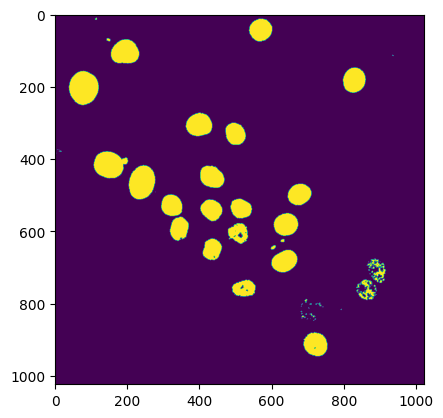

In [ ]:
p = clf.predict(flat_features)
plt.imshow(p.reshape(image.shape))

In [ ]:
import pickle
with open(f'{BASE_PATH}/svm1000.pkl', 'wb') as f:
  pickle.dump(clf, f)

In [ ]:
with open(f'{BASE_PATH}/svm1000.pkl', 'rb') as f:
  clf2 = pickle.load(f)

In [ ]:
def test_image(image, clf, window_size=5, probs=False):
  height, width = image.shape
  image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
  flat_features = image_features.reshape(height*width, window_size**2)
  if probs:
    # May not work with all models
    y = clf.predict_proba(flat_features).reshape(image.shape+(2,))
  else:
    y = clf.predict(flat_features).reshape(image.shape)
  return y

In [ ]:
p = test_image(image, clf2) # May be slow ish

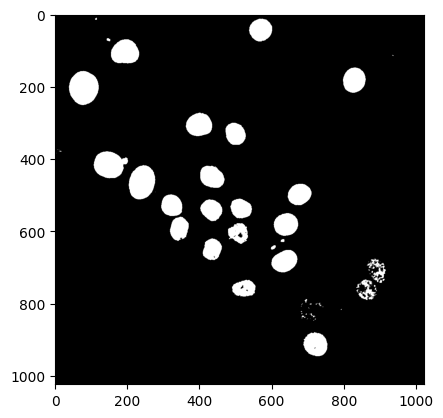

In [ ]:
plt.imshow(p, cmap='gray')

In [ ]:
compute_jaccard_index_for_matches(target_image, p)

(0.8179177264457824,
 {1: 0.9197851988588689,
  2: 0.9167666106980091,
  3: 0.8918832210458775,
  4: 0.8932518906340896,
  5: 0.8598536188669016,
  6: 0.8690869086908691,
  8: 0.5485001947798988,
  9: 0.5457413249211357,
  10: 0,
  15: 0.9034422403733956,
  16: 0.8445131375579599,
  23: 0.885686274509804,
  24: 0.8927514792899408,
  25: 0.8304301457518664,
  26: 0.8848733233979136,
  27: 0.87829209896249,
  28: 0.8680430879712747,
  29: 0.8788778877887788,
  30: 0.890738369611609,
  31: 0.9011827546737886,
  32: 0.9125412541254125,
  33: 0.8616894705532421,
  34: 0.9341772151898734})

You are to prepare a table comparing several methods of segmenting the cells.
1.  Use a Naive Bayesian classifier [sklearn.naive_bayes.GaussianNB](https://letmegooglethat.com/?q=sklearn+nauive+bayes)
2.  Use logistic regression [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
3.  Use a SVM (play with different kernels - I demoed RBF only)
4.  Use a neural network (on the features) (use sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html))
5.  Use a convnet (on the original image) either of your own design or one of the pytorch models (such as [`FCN_ResNet`](https://colab.research.google.com/drive/1zgnXGmV7EVqAi8XnQc2qvBmDn7ArIrtG?usp=drive_fs#scrollTo=337f8b00-aee6-4072-8540-64b57ad37ba9))

In addition, you can explore ways to preprocess the image (histogram equalization, denoising) or postprocess in order to improve results.


# Approach
Put your code and explanation in this section

# Results

Use the snippets below to create a table of results.
When grading, I will look at this table to see if it is consistent with what the numbers should-be and if it is complete.


In [ ]:
import pandas as pd
import numpy as np

# Define methods as columns -- customize if you add more
methods = ['Naive Bayes', 'LogReg', 'SVM(Linear)', 'SVM(RbF)', 'Net (v1)', 'CNN']

# Define the variations heirarchically -- customize if you want to
# add other variations or other datasets from the contest site
datasets = {
    'Fluo-N2DH-GOWT1': {
        'ST': {'01', '02'},
        # 'GT': {'01', '02'}
    }
}

# Creating MultiIndex for rows
rows = []
for dataset, subsets in datasets.items():
    for subset, tracks in subsets.items():
        for track in tracks:
            rows.append((dataset, subset, track))

# Creating the DataFrame
multi_index = pd.MultiIndex.from_tuples(rows, names=['Dataset', 'Truth', 'Track'])
df = pd.DataFrame(index=multi_index, columns=methods).astype(float)


In [ ]:
# Set the mIoU score for an experiment
df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'Naive Bayes'] = 0.00 # Whatever you get

# Display the updated DataFrame
display(df)


Naive Bayes  LogReg  SVM(Linear)  SVM(RbF)  \
Dataset         Truth Track                                               
Fluo-N2DH-GOWT1 ST    01             0.0     NaN          NaN       NaN   
                      02             NaN     NaN          NaN       NaN   

                             Net (v1)  CNN  
Dataset         Truth Track                 
Fluo-N2DH-GOWT1 ST    01          NaN  NaN  
                      02          NaN  NaN

# Submission

1.  Your solution should be contained within one notebook, with plenty of visualizations.
3.  Download your soution as a .ipynb file
4.  Use [my nbconvert notebook](https://colab.research.google.com/drive/13GvgiBl_jbGi3OSFbGAofmUBbh8yhOht#scrollTo=hiz8-EeUw95e) to create a PDF or docx to submit.